# TP4 - Background Substraction
ATRIM - Option Datasim

Ecole Centrale Nantes

Diana Mateus

Participants: Yueying CAO

### BACKGROUND SUBSTRACTION 

The goal of this TP is to enhance the video of a neurointervention  to improve the visualization of moving tools. To this end you will implement a pipeline of image processing methods to detect the moving tools automatically. 


#### Methodology

As the brain is mostly static one way to detect the moving tools is to substract the background (first image) from each of the subsequent images. However, the results of this step need to be further improved. To this end, you will design a pipilene with the methods learnt in this course to produce a binary mask for the pixels that belong to the tools. 

In your pipeline use at least:
- one histogram transformation
- one morphological operation
- one filtering operation in the spatial domain
- one filtering operation in the spectral domain
- one segmentation method

_The same pipeline should be applied to every image_


#### Expected output

The output of your image processing pipeline should be one binary image mask (with values 0 or 1) for every input image of the sequence, where 
- the zero valued pixels indicate the moving tools inside each image.  
- the pixels with value 1 indicate the background (not a moving tool)

To validate the proposed method, a human has annotated (manually drawn) the tools of interest within the images. The annotated pixels belong either to catheters or guidewires. **Your masks should be as close as possible to the human annotations.**


#### Visualization of data and manual annotations

- Data visualization  (**do not include in final version**): visualize the neurointervention images in the ``` catheter``` folder with name ```frame_#```

- Individual Annotation visualization  (** do not include in final version**): visualize the manual annotations in the ```catheter``` folder with names ``` #_MicroCath``` and ```#_GuideWire```. 

- Individual Annotation visualization  (** do not include in final version**): visualize the full manual annotation (union of the guidewire and microcatheter masks) by composing the union of the ``` #_MicroCath``` and ```#_GuideWire```. It should also be a binary mask.



#### Experimental (quantitative and qualitative  validation)

To compare your results and the manual annotations use the mean SAD (Sum of Absolute Differences) and the SNR (Signal to Noise Ratio) errors between your  mask and  the **full** manual mask. 

Present the results qualitatively and quantitatively:

- Qualitatively: 
     - Show your mask side by side with the manually annotated mask
     - Create an enhanced image suitable for guidance: enhance the contrast of the image and overlay your mask on the green channel of the enhanced image.

- Quantitatively: 
    - compute and print the SAD (sum of absolute differences) error per image. 
    - compute and print the MSE (sum of squared  differences ) error per image.
    - compute and print the PSNR (Peak signal to noise ratio) taking as reference image the manual annotations. 
    - Then compute and print the mean and standard deviation of the three measures (SAD, MSE and PSNR) over the entire sequence.
    
Hints:
```
mse = numpy.mean( (img1 - img2) ** 2 )
PIXEL_MAX = 255.0 #or 1.0 or max over the signal of interest
psnr = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
```
or look at ```skimage.measure``` module

You may use modules such as ```scipy```, ```skimage``` or ``sklearn``(e.g. for clustering with K-means or a Gaussian Mixture Model). Ask me for other external modules.


### REPORT INSTRUCTIONS

#### 1. Intermediate Steps (Code and Description)
Report the results of the intermediate steps (when you add or remove a method from the pipeline):
- provide a text introduction with the idea that you intend to try
- show the implementation of the idea with code 
- evaluate the quantitative and qualitative changes  when including, varying, adapting, etc the proposed method
- Discuss the scores or visualization improvements/degradations 

#### 2. Final Pipeline (Code and Description)
Provide a detailed description of the best performing pipeline. Comment the code such that it is straightforward to relate the pipeline description to the code. Add your conclusions

- Describe the final retained pipeline
- Give a justification for every step (e.g. supported by experimental intermediate steps or theory). 
- Add the **commented** code
- Display the qualitative and quantitative results 
- Give your conclusions

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import skimage.io as io
from scipy import ndimage
from skimage.transform import resize
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk

In [2]:
IMDIR = './catheter'

Text(0.5, 1.0, 'frame with microcatheter and guide wire')

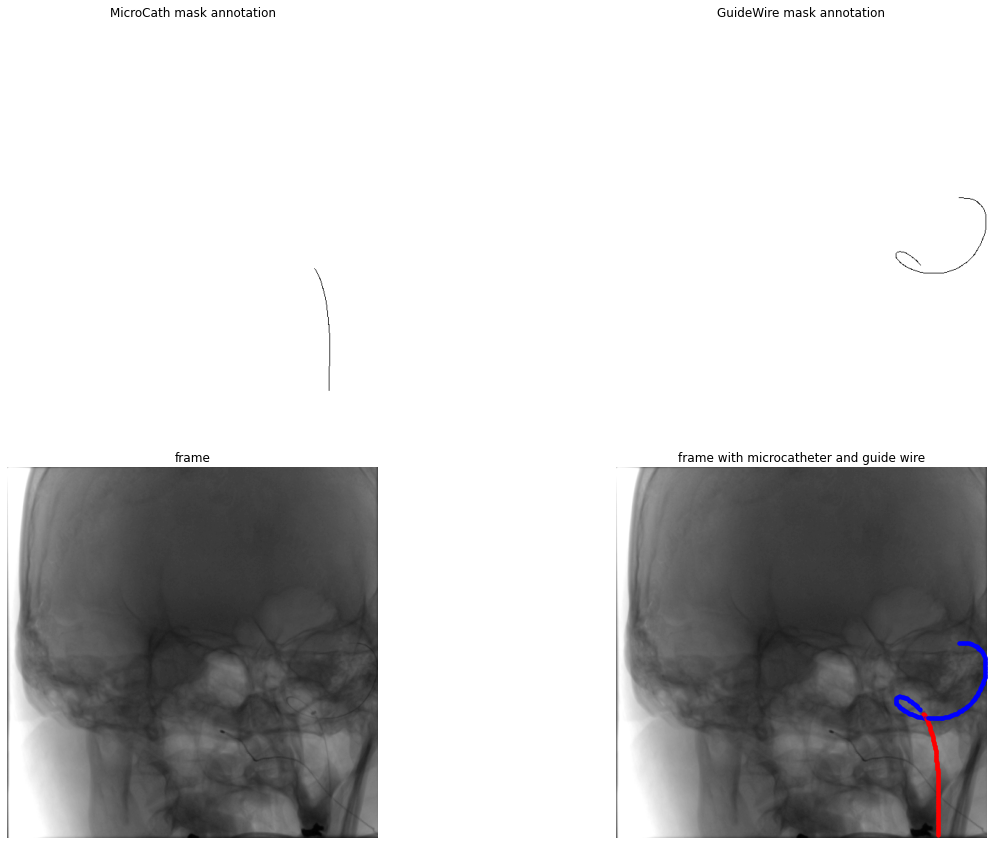

In [8]:
# Data visualization
## visualize data
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]

img = IMDIR+'./frame_241'
img = io.imread(img,as_gray=True)
img = img/255

plt.subplot(2,2,3)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('frame')   

mcath = IMDIR+'/241_MicroCath.tiff'
mcath = io.imread(mcath)
if len(mcath.shape) ==3:
    mcath = mcath[:,:,0]
mcath = mcath/255
plt.subplot(2,2,1)
plt.imshow(mcath,cmap='gray')
plt.axis('off')
plt.title('MicroCath mask annotation')

gwire = IMDIR+'/241_GuideWire.tiff'
gwire = io.imread(gwire)
if len(gwire.shape) ==3:
    gwire = gwire[:,:,0]
gwire = gwire/255
plt.subplot(2,2,2)
plt.imshow(gwire,cmap='gray')
plt.axis('off')
plt.title('GuideWire mask annotation')

plt.subplot(2,2,4)
plt.imshow(img,cmap='gray')
union = np.ones((img.shape))
for i in range(img.shape[1]):
    for j in range(img.shape[0]):
        if mcath[j,i] == 0:
            plt.plot(i,j,'.r')
            union[j,i] = 0
        elif gwire[j,i] == 0:
            plt.plot(i,j,'.b') 
            union[j,i] = 0
plt.axis('off')
plt.title('frame with microcatheter and guide wire')



In [66]:
### following are final pipeline

In [67]:
def normalize(img):
    img = (img-img.min())/(img.max()-img.min())
    return img

def hist_equali(img):
    # will return the equalized image within (0,1)
    hist, bin_limits = np.histogram(img, bins=256)
    cdf = hist.cumsum()            # cumulative distribution function
    cdf = (cdf - cdf.min()) * (255 - 0) / (cdf.max() - cdf.min()) + 0
    result = np.interp(img.flatten(),bin_limits[:-1],cdf)
    result = normalize(result)
    return result.reshape(img.shape)

def binarize(img, k):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] < k:
                img[i,j] = 0
            else:
                img[i,j] = 1
    return img

def binarize_like(img, k):
    # Binarization
    a = 0.5-k
    b = 0.5+k
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] < b and img[i,j] > a:
                img[i,j] = 1
    return img

def gaussianKernel(hs,sig): #half window size and Gaussian sigma
    kernel = np.zeros((hs*2+1,hs*2+1))
    ax = np.arange(-hs, hs+1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))
    return kernel / np.sum(kernel)      # normalization

def gaussian_Blur(img, hs=1, sig=1):
    kernel = gaussianKernel(hs, sig)
    img_blur = ndimage.convolve(img,kernel)
    return img_blur

def Sobel_kernel():
    # Sobel filters
    grad_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    grad_y = np.transpose(grad_x)
    return grad_x, grad_y

def derivative_filter(img):
    grad_x, grad_y = Sobel_kernel()
    gradX = ndimage.convolve(img,grad_x)
    gradY = ndimage.convolve(img,grad_y)
            
    img_xy = np.sqrt(gradY**2+gradY**2)
    img_xy = normalize(img_xy)
    return img_xy

def low_pass_kernel(P, Q, filter_type, D0):
    D = np.zeros((P,Q))
    H = np.copy(D)
    for i in range(P):
        for j in range(Q):
            D[i,j] = np.sqrt((i-P/2)**2 + (j-Q/2)**2)
            if filter_type =='ideal':
                if D[i,j] < D0:
                    H[i,j] = 1
                else:
                    H[i,j] = 0
            elif filter_type =='gaussian':
                H[i,j] = np.exp(-D[i,j]**2/(2*D0**2))
            else: 
                print('Please input the type of the filter, Gaussian or Ideal')
                
    return H
            
def low_pass_filter(img, filter_type, D0):
    # step1: padding
    P = img.shape[0]*2
    Q = img.shape[1]*2
    img_pad = np.zeros((P,Q))
    img_pad[0:img.shape[0],0:img.shape[1]] = img
    
    # step2: Compute the DFT and shift to the center
    img_fft = np.fft.fft2(img_pad)
    img_shift = np.fft.fftshift(img_fft)
    
    # step3: Construct a real, symmetric filter
    H_low = low_pass_kernel(P, Q, filter_type, D0)
    
    # step4: Compute the product
    G_low = H_low*img_shift
    
    # step5: Obtained the fitered image by computing the IDFT
    img_low = np.real(np.fft.ifft2(np.fft.ifftshift(G_low))) 
    
    # step6: Extract the image region
    img_low = img_low[0:img.shape[0],0:img.shape[1]]
    
    return img_low
    
def high_pass_filter(img, filter_type, D0):
    H = 1 - low_pass_filter(img, filter_type, D0)
    
    return H

In [68]:
# final processing function
# can be used for single frame and union, need to set plt.figure() before calling.
def extract_moving(frame, union, index):
    # compute the difference between current frame and intial frame to capture the moving part
    diff = frame - init
    diff = normalize(diff)     # histogram normalization
    
    # set a threshold to only keep the pixel value in specific range
    threshold = 0.1
    diff_bi = binarize_like(diff, threshold)
    
    # use Sobel kernel to do the derivative filtering
    diff_deri = derivative_filter(diff_bi)
    
    # do a morphological operation
    selem = disk(5)   # try with different size of element
    diff_mor = 1-(diff_deri - erosion(diff_deri, selem))
    
    # cheating part
    # directly set the constant background region as 1
    diff_mor[0:190,0:500] = 1
    diff_mor[350:diff.shape[0],0:400] = 1
    diff_mor[350:diff.shape[0],460:diff.shape[1]] = 1

    # Binarization operation
    diff_mor = diff_mor*255
    threshold = 190
    diff_bi = binarize(diff_mor,threshold)
        
    # region growing
    # didn't work
#     seed = [(422,332)]    # one point on wire appeared in every frame
#     # set the searching range
#     xlim = [0,500]
#     ylim = [200,300]
#     seedmark = region_grow(diff_bi,seed, 0.2, xlim, ylim, p=8)

    plt.subplot(1,2,1)
    plt.imshow(diff_bi,cmap='gray')
    plt.axis('off')
    plt.title('final substraction')


    plt.subplot(1,2,2)
    plt.imshow(union, cmap='gray')
    plt.axis('off')
    plt.title('manual annotation')
    
    # Mesure and calculus 
    sad = np.sum(abs(diff_bi-union))
    mse = np.mean((diff_bi-union)**2)
    psnr = 20*math.log10(1/math.sqrt(mse))
    
    print('For frame_2' + str(index) +'1:')
    print('SAD='+str(round(sad,2))+', MSE='+str(round(mse,4))+', PSNR='+str(round(psnr,2)))
    
    return sad, mse, psnr

For frame_211:
SAD=286.0, MSE=0.0011, PSNR=29.62
For frame_221:
SAD=666.0, MSE=0.0025, PSNR=25.95
For frame_231:
SAD=1341.0, MSE=0.0051, PSNR=22.91
For frame_241:
SAD=1412.0, MSE=0.0054, PSNR=22.69
For frame_251:
SAD=1886.0, MSE=0.0072, PSNR=21.43
For frame_261:
SAD=2860.0, MSE=0.0109, PSNR=19.62
For frame_271:
SAD=1449.0, MSE=0.0055, PSNR=22.57
For frame_281:
SAD=2034.0, MSE=0.0078, PSNR=21.1
For frame_291:
SAD=2914.0, MSE=0.0111, PSNR=19.54
Mean SAD of sequence is 1649.78
Mean MSE of sequence is 0.0063
Mean PSNR of sequence is 22.83


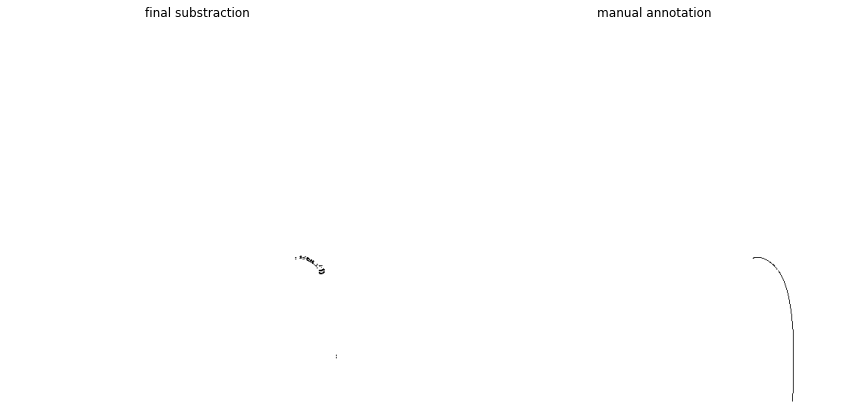

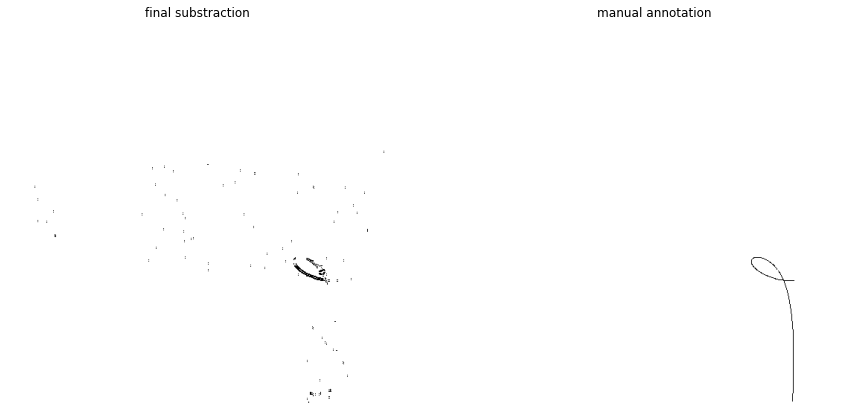

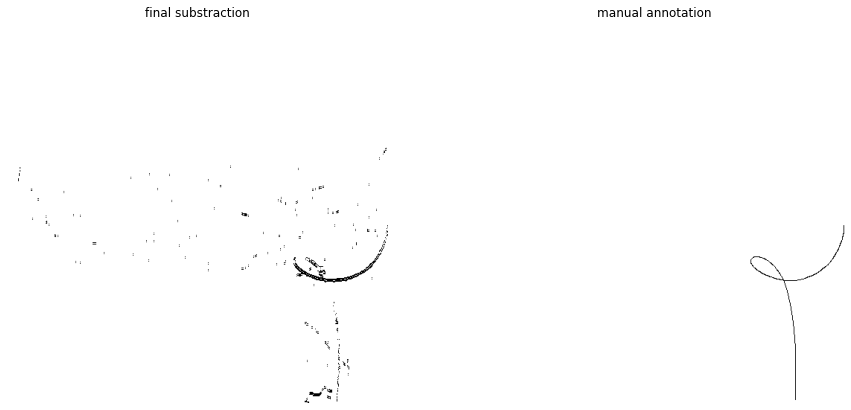

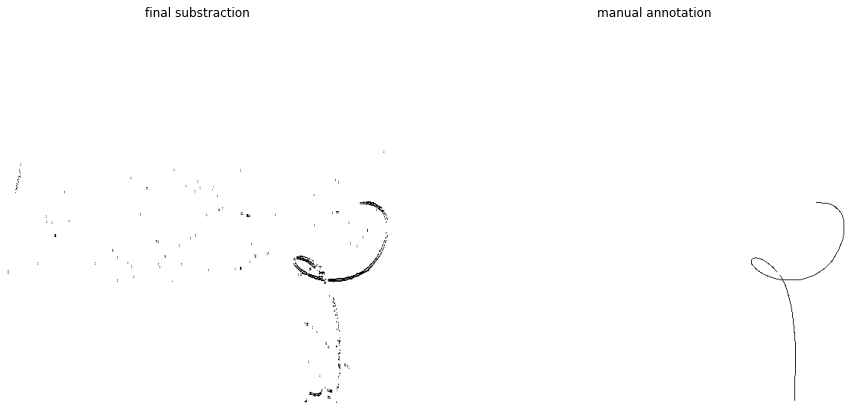

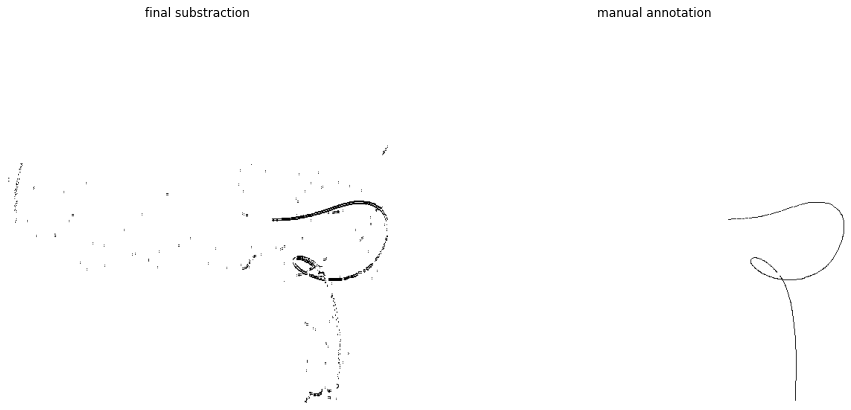

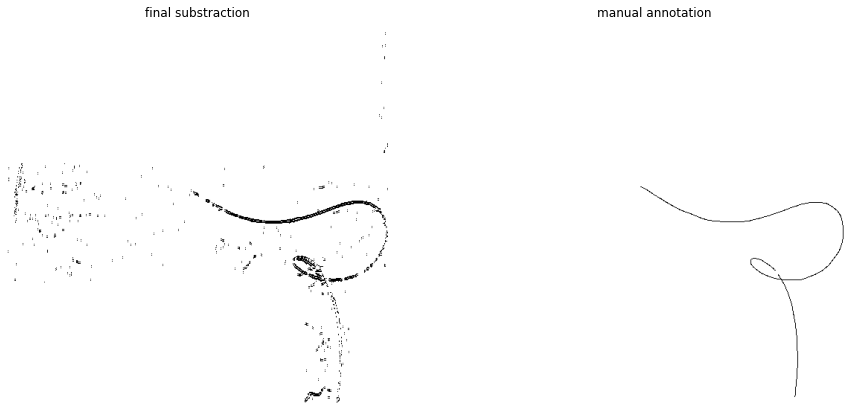

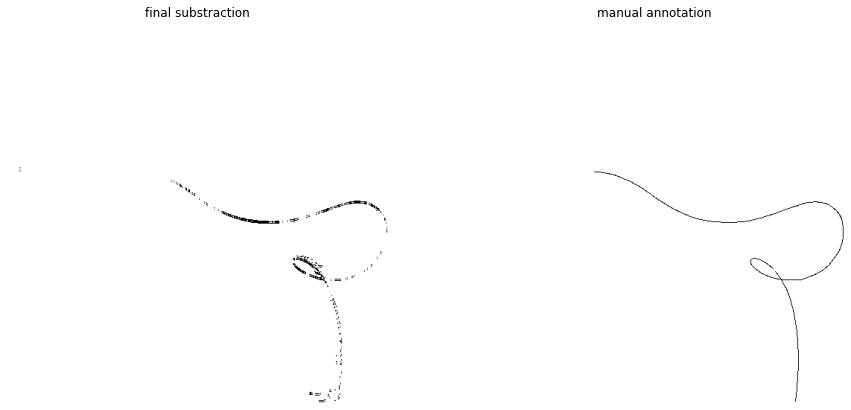

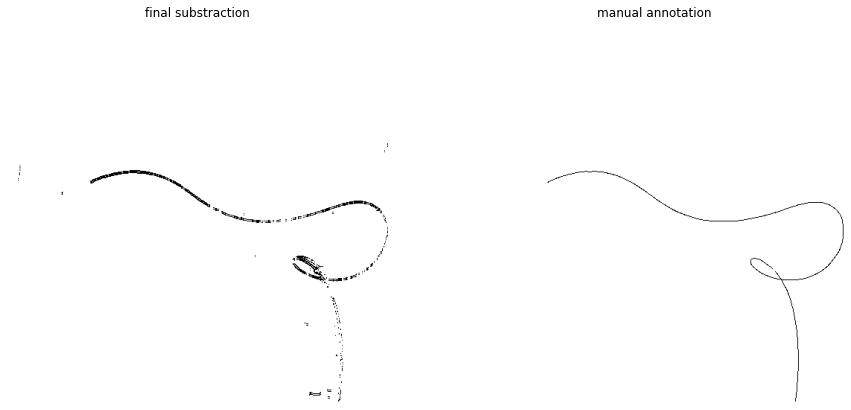

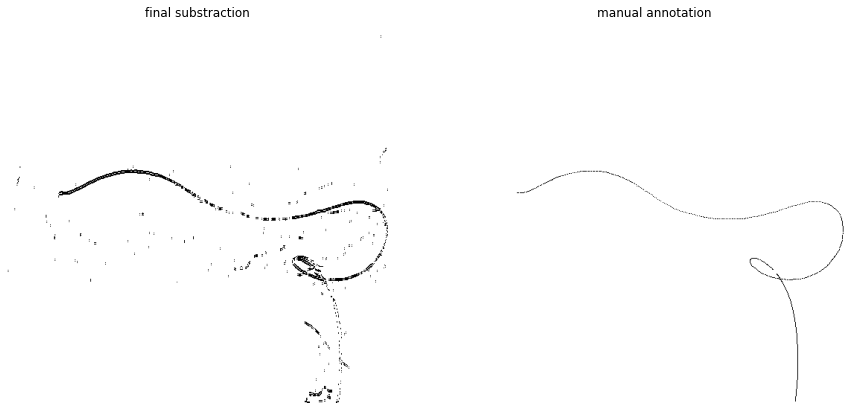

In [69]:
width=15
height=15
plt.rcParams['figure.figsize'] = [width, height]

# use grame_201 as the intial constant image to find the difference value which is the moving part
init = IMDIR+'./frame_201'
init = io.imread(init, as_gray=True)
init = normalize(init)
# plt.imshow(init,cmap='gray')
# plt.title('initial frame (frame_201)')
# plt.axis('off')

[SAD, MSE, PSNR] = [[],[],[]]


for index in range(1,10):
    frame = IMDIR + './frame_2' + str(index) +'1'
    frame = io.imread(frame,as_gray=True)
    frame = normalize(frame)
    
    mcath = IMDIR+'./2' + str(index) + '1_MicroCath.tiff'
    mcath = io.imread(mcath)
    if len(mcath.shape) ==3:
        mcath = mcath[:,:,0]
    mcath = mcath/255
    gwire = IMDIR+'/2' + str(index) + '1_GuideWire.tiff'
    gwire = io.imread(gwire)
    if len(gwire.shape) ==3:
        gwire = gwire[:,:,0]
    gwire = gwire/255
    union = np.ones((frame.shape))
    for i in range(frame.shape[1]):
        for j in range(frame.shape[0]):
            if mcath[j,i] == 0:
                union[j,i] = 0
            elif gwire[j,i] == 0:
                union[j,i] = 0

    plt.figure()
    sad, mse, psnr = extract_moving(frame, union, index)
    
    SAD.append(sad)
    MSE.append(mse)
    PSNR.append(psnr)
    
    
print('Mean SAD of sequence is ' + str(round(np.mean(SAD),2)))
print('Mean MSE of sequence is ' + str(round(np.mean(MSE),4)))
print('Mean PSNR of sequence is ' + str(round(np.mean(PSNR),2)))
